In [1]:
import numpy as np
import matplotlib.pyplot as plt

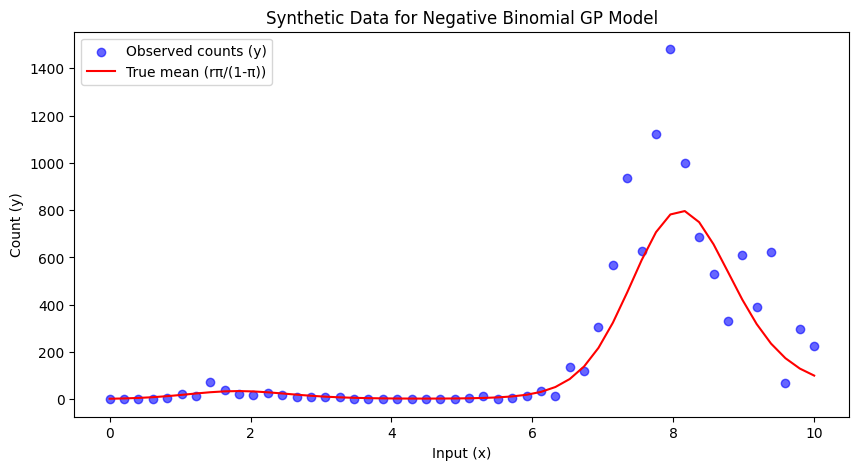

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic 1D inputs (e.g., time, price, or any feature)
N = 50  # Number of data points
X = np.linspace(0, 10, N).reshape(-1, 1)  # Shape (N, 1)

# Define a latent function f(x) (ground truth)
def true_latent_function(x):
    return 2 * np.sin(x) + 0.5 * x  # Arbitrary smooth function

# Compute latent function values
f_true = true_latent_function(X).flatten()

# Define dispersion parameter (r > 0)
r = 2.0

# Transform f_true to probabilities using sigmoid (π = σ(f))
pi_true = 1 / (1 + np.exp(-f_true))

# Generate negative binomial counts (y_n)
# Negative binomial: y ~ NB(r, p=1-π), but parameterized as in your likelihood
y = np.random.negative_binomial(n=r, p=1 - pi_true)

# Plot the data
plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='blue', label='Observed counts (y)', alpha=0.6)
plt.plot(X, r * pi_true / (1 - pi_true), color='red', label='True mean (rπ/(1-π))')
plt.xlabel("Input (x)")
plt.ylabel("Count (y)")
plt.title("Synthetic Data for Negative Binomial GP Model")
plt.legend()
plt.show()

In [10]:
def MAP(K, y, r, max_iter=100, tol=1e-6):
        N = len(y) 
        f = np.zeros(N)
        for _ in range(max_iter):
            pi = 1 / (1 + np.exp(-f))
            grad = -K @ f + y * (1 - pi) - r * pi
            W = pi * (1 - pi) * (y + r)
            H = -np.linalg.inv(K) - np.diag(W)
            delta = np.linalg.solve(H, grad) # Newton step
            f -= delta # update f 
            if np.linalg.norm(delta) < tol:
                break
        return f

In [11]:
def laplace_approx(K, y, r):
        f_map = MAP(K, y, r) # find the MAP
        pi_map = 1 / (1 + np.exp(-f_map))
        W_map = np.diag(pi_map * (1 - pi_map) * (y + r))
        H = -np.linalg.inv(K) - W_map
        Sigma = np.linalg.inv(-H)
        return f_map, Sigma

/var/folders/by/0tg5l6wj7g5bb2fr6pb_1p200000gn/T/ipykernel_99702/628125969.py:5: RuntimeWarning: overflow encountered in exp
  pi = 1 / (1 + np.exp(-f))
/var/folders/by/0tg5l6wj7g5bb2fr6pb_1p200000gn/T/ipykernel_99702/118375488.py:3: RuntimeWarning: overflow encountered in exp
  pi_map = 1 / (1 + np.exp(-f_map))
/var/folders/by/0tg5l6wj7g5bb2fr6pb_1p200000gn/T/ipykernel_99702/296473196.py:16: RuntimeWarning: overflow encountered in exp
  plt.plot(X, r * (1 / (1 + np.exp(-f_map))) / (1 - (1 / (1 + np.exp(-f_map)))),
/var/folders/by/0tg5l6wj7g5bb2fr6pb_1p200000gn/T/ipykernel_99702/296473196.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(X, r * (1 / (1 + np.exp(-f_map))) / (1 - (1 / (1 + np.exp(-f_map)))),
/var/folders/by/0tg5l6wj7g5bb2fr6pb_1p200000gn/T/ipykernel_99702/296473196.py:20: RuntimeWarning: invalid value encountered in sqrt
  r * (1 / (1 + np.exp(-(f_map - 1.96 * np.sqrt(np.diag(Sigma)))))) / (1 - (1 / (1 + np.exp(-(f_map - 1.96 * np.sqrt(np.diag(Sigma)

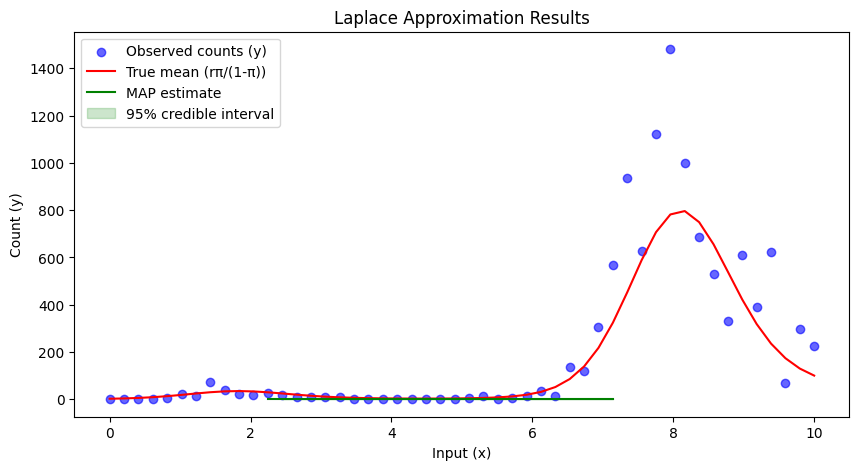

In [12]:
# Define an RBF kernel (for covariance matrix K)
def rbf_kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    sq_dist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 * sq_dist / length_scale**2)

# Compute covariance matrix K
K = rbf_kernel(X, X, length_scale=1.0)

# Run MAP estimation and Laplace approximation
f_map, Sigma = laplace_approx(K, y, r)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='blue', label='Observed counts (y)', alpha=0.6)
plt.plot(X, r * pi_true / (1 - pi_true), color='red', label='True mean (rπ/(1-π))')
plt.plot(X, r * (1 / (1 + np.exp(-f_map))) / (1 - (1 / (1 + np.exp(-f_map)))), 
         color='green', label='MAP estimate')
plt.fill_between(
    X.flatten(),
    r * (1 / (1 + np.exp(-(f_map - 1.96 * np.sqrt(np.diag(Sigma)))))) / (1 - (1 / (1 + np.exp(-(f_map - 1.96 * np.sqrt(np.diag(Sigma))))))),
    r * (1 / (1 + np.exp(-(f_map + 1.96 * np.sqrt(np.diag(Sigma)))))) / (1 - (1 / (1 + np.exp(-(f_map + 1.96 * np.sqrt(np.diag(Sigma))))))),
    color='green', alpha=0.2, label='95% credible interval'
)
plt.xlabel("Input (x)")
plt.ylabel("Count (y)")
plt.title("Laplace Approximation Results")
plt.legend()
plt.show()

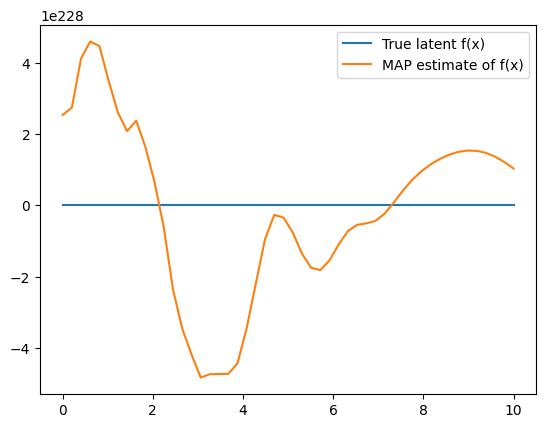

In [13]:
plt.plot(X, f_true, label="True latent f(x)")
plt.plot(X, f_map, label="MAP estimate of f(x)")
plt.legend(); plt.show()